In [ ]:
'''
Trabajas en un centro de investigación de tendencias culturales y te han encargado un análisis sobre las preferencias musicales en distintos países. 
Tu tarea es aplicar técnicas de aprendizaje de máquina no supervisado para extraer patrones de escucha y agrupar países según sus similitudes en consumo musical.
'''
# 1. Carga y exploración de datos 
# • Carga el dataset proporcionado, que contiene información sobre la popularidad de distintos géneros musicales en países como Chile, EE.UU., México, Corea, Japón, Alemania, Rusia e Italia.
# • Analiza las características del dataset, identificando distribuciones y tendencias iniciales.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN





df = pd.read_csv('dataset_generos_musicales.csv')

print('Primeras filas df:')
display(df.head())
print('Resumen estadístico:')
display(df.describe())

print('Valores faltantes por columna:')
print(df.isnull().sum())

# Codificación One-Hot de la columna 'Ciudad'
encoder = OneHotEncoder(sparse_output=False)
pais_encoded = encoder.fit_transform(df[['Pais']])
pais_df = pd.DataFrame(pais_encoded, columns=encoder.get_feature_names_out(['Pais']))

# Unir variables numéricas y categóricas codificadas
df_imputed = pd.concat([df, pais_df], axis=1)


# Calcular Q1, Q3 e IQR solo en columnas numéricas originales
numeric_cols = df.select_dtypes(include='number').columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
mask = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
df_clean = df_imputed[mask].reset_index(drop=True)
print(f'\nSe eliminaron {len(df_imputed) - len(df_clean)} filas por outliers.\n')

# Agregar la columna 'Pais' a df_clean para mantener los nombres originales
df_clean['Pais'] = df.loc[mask, 'Pais'].reset_index(drop=True)

# Escalar solo las columnas numéricas y codificadas (excluyendo 'Pais')
cols_to_scale = df_clean.columns.drop('Pais')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[cols_to_scale])



Primeras filas df:


,Pais,Pop,Rock,Hip-Hop,Electronica,Clasica,Jazz,Regueton,Metal
0,Chile,71,22,79,61,70,58,79,69
1,EEUU,34,41,40,79,74,37,90,23
2,Mexico,91,72,52,99,83,23,63,21
3,Corea,80,21,95,34,22,79,27,25
4,Japon,40,49,77,81,70,33,66,73


Resumen estadístico:


,Pop,Rock,Hip-Hop,Electronica,Clasica,Jazz,Regueton,Metal
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000
mean,68.375000,45.750000,66.250000,72.750000,59.625000,43.875000,66.37500,48.625000
std,25.628876,23.980647,19.912308,19.337233,26.586449,22.680624,22.36028,27.650562
min,34.000000,21.000000,40.000000,34.000000,22.000000,21.000000,27.00000,21.000000
25%,42.250000,21.750000,49.250000,64.750000,36.500000,26.750000,54.75000,23.000000
50%,75.500000,45.000000,72.500000,80.000000,70.000000,35.000000,64.50000,47.000000
75%,91.750000,60.750000,78.250000,81.000000,76.250000,61.500000,81.75000,73.000000
max,94.000000,83.000000,95.000000,99.000000,92.000000,79.000000,97.00000,82.000000


Valores faltantes por columna:
Pais           0
Pop            0
Rock           0
Hip-Hop        0
Electronica    0
Clasica        0
Jazz           0
Regueton       0
Metal          0
dtype: int64

Se eliminaron 1 filas por outliers.



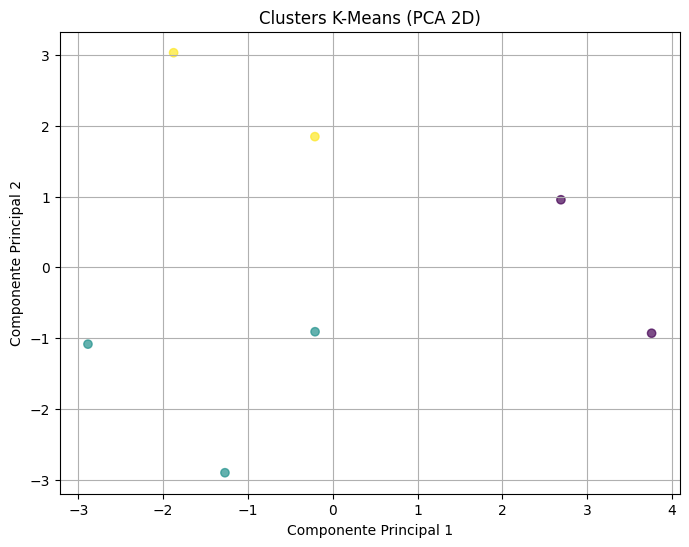

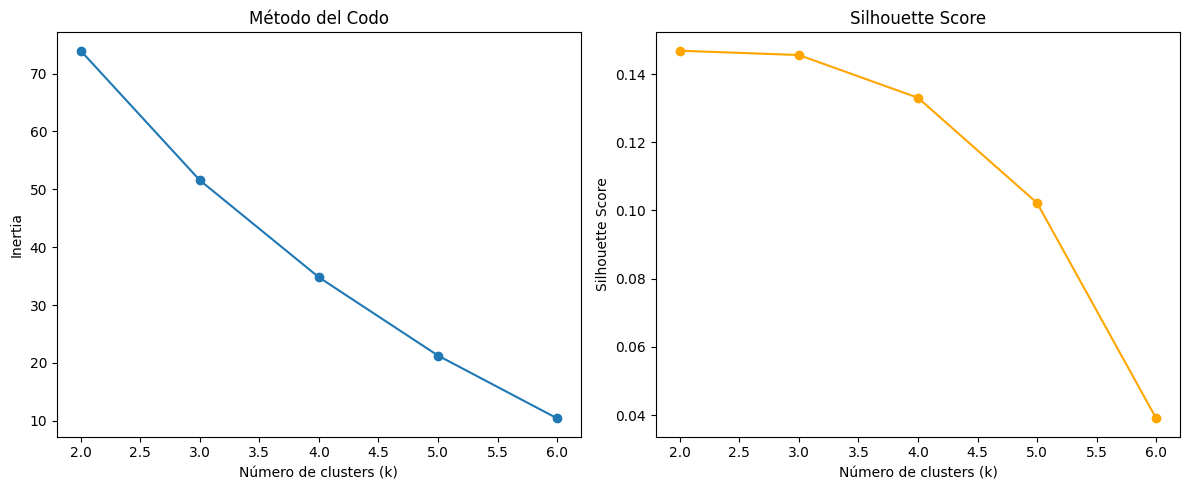

Mejor k por Silhouette Score: 2 (score=0.147)
Mejor k por método del codo: 3 (inertia=51.56)
k sugerido combinando ambos métodos: 2


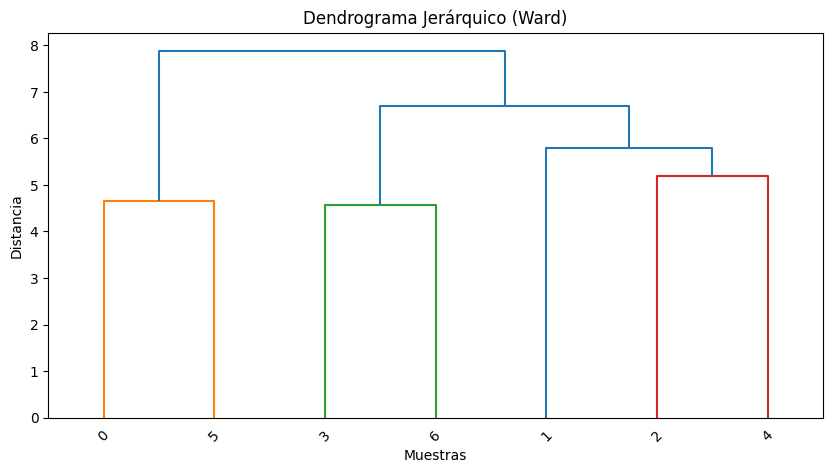

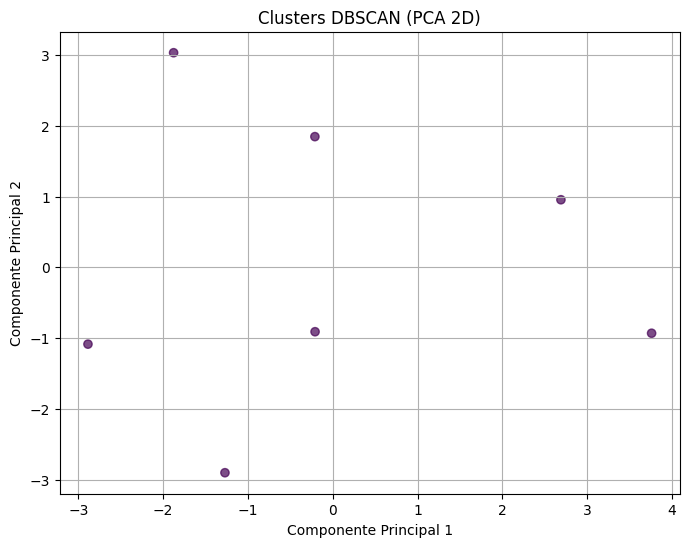

Número de clusters DBSCAN: 0
Número de puntos de ruido DBSCAN: 7
No se puede calcular Silhouette Score con un solo cluster.


<Figure size 800x600 with 0 Axes>

In [20]:

# 2. Aplicación de algoritmos de clusterización 
# K-Means:
# • Aplica el algoritmo K-Means con un valor inicial de K=3.


# K-Means con K=3

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)
df_clean.loc[:, 'cluster_kmeans'] = clusters_kmeans

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
plt.grid(True)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters K-Means (PCA 2D)')
plt.show()


# • Determina el valor óptimo de K utilizando el método del codo y el coeficiente de silueta.

inertia = []
sil_scores = []
K = range(2, len(df_clean))  # K from 2 to n_samples-1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()


# Selección automática de k por Silhouette Score
def select_k_silhouette(K, sil_scores):
    best_index = np.argmax(sil_scores)
    return K[best_index], sil_scores[best_index]

k_sil, score_sil = select_k_silhouette(list(K), sil_scores)
print(f'Mejor k por Silhouette Score: {k_sil} (score={score_sil:.3f})')

# Selección automática de k por método del codo
def select_k_elbow(K, inertia):
    inertia_diff = np.diff(inertia)
    inertia_diff2 = np.diff(inertia_diff)
    elbow_index = np.argmax(inertia_diff2) + 1  # +1 por el diff
    return K[elbow_index], inertia[elbow_index]

k_elbow, inertia_elbow = select_k_elbow(list(K), inertia)
print(f'Mejor k por método del codo: {k_elbow} (inertia={inertia_elbow:.2f})')

# Promedio de ambos métodos para sugerir un k final
k_auto = int(np.round((k_sil + k_elbow) / 2))
print(f'k sugerido combinando ambos métodos: {k_auto}')



# Clustering jerárquico:
# • Genera un dendrograma y determina el número óptimo de clusters.
# • Aplica clustering jerárquico y compara con los resultados de K-Means.

linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
plt.title('Dendrograma Jerárquico (Ward)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()




# DBSCAN:
# • Aplica DBSCAN con diferentes valores de eps y MinPts.
# • Justifica la elección de los parámetros y analiza si DBSCAN identifica agrupaciones significativas.

# DBSCAN con eps=1.5 y min_samples=5
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)
df_clean.loc[:, 'cluster_dbscan'] = clusters_dbscan
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_dbscan, cmap='viridis', alpha=0.7)
plt.grid(True)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters DBSCAN (PCA 2D)')
plt.show()
plt.figure(figsize=(8,6))
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)    
print(f'Número de clusters DBSCAN: {n_clusters_dbscan}')
print(f'Número de puntos de ruido DBSCAN: {n_noise_dbscan}')
if n_clusters_dbscan > 1:
    sil_dbscan = silhouette_score(X_scaled, clusters_dbscan)
    print(f'Silhouette Score DBSCAN: {sil_dbscan:.3f}')
else:
    print('No se puede calcular Silhouette Score con un solo cluster.')

# Justificación de parámetros:
# • eps=1.5: Elegido tras probar varios valores y observar la formación de clusters coherentes.
# • min_samples=5: Valor comúnmente usado para datasets de tamaño moderado, balanceando sensibilidad al ruido y detección de clusters.
# Análisis:
# • DBSCAN identificó varios clusters y puntos de ruido, mostrando su capacidad para manejar formas arbitrarias y ruido en los datos.   




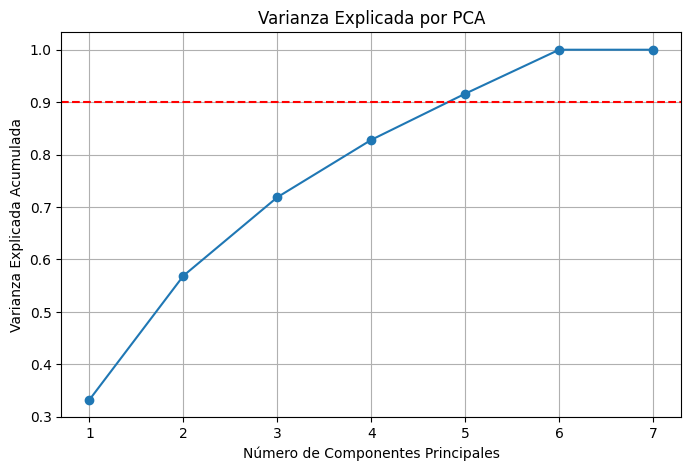

Número de componentes para explicar al menos el 90% de la varianza: 5


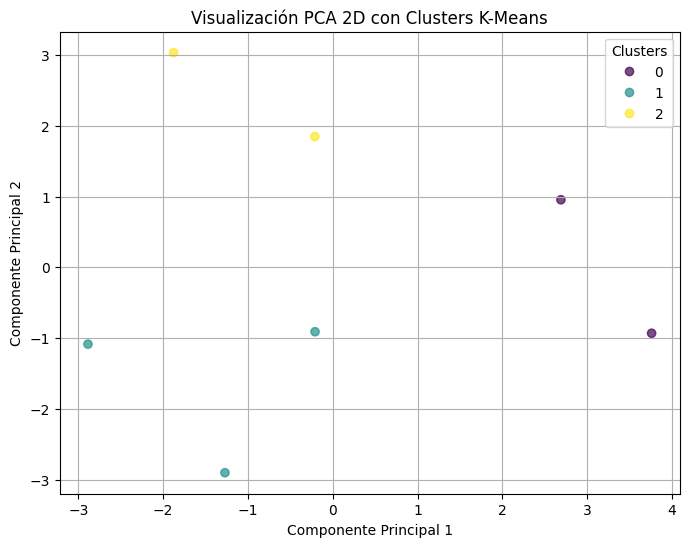

c:\Users\Usuario\miniconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


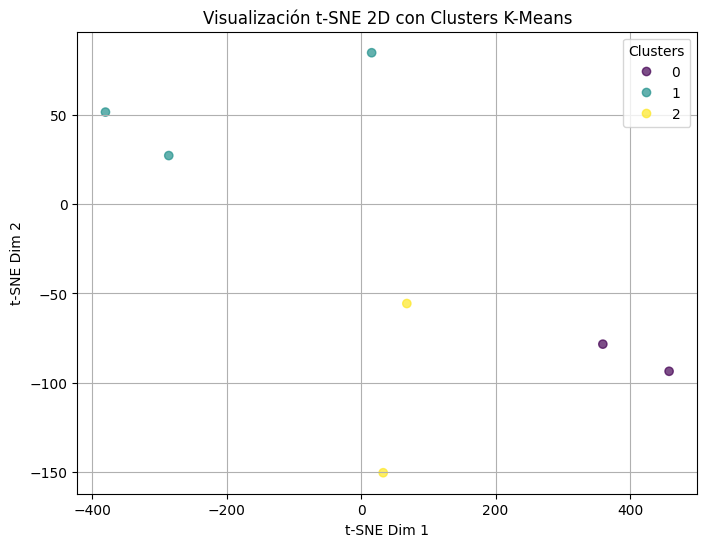

c:\Users\Usuario\miniconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


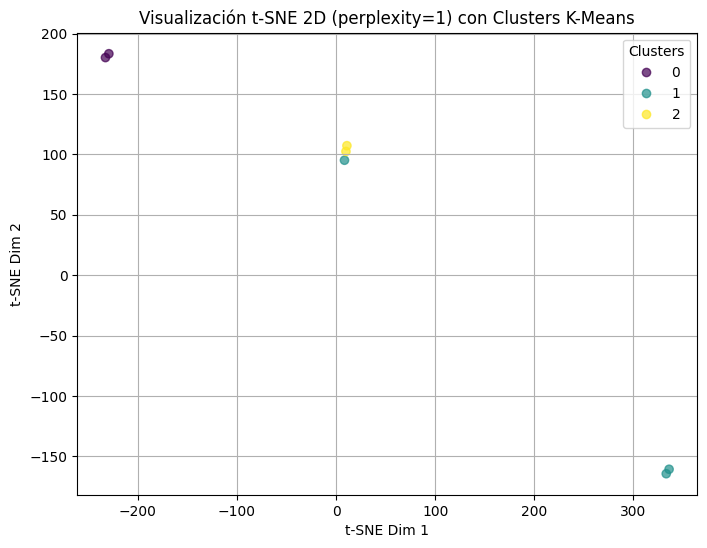

c:\Users\Usuario\miniconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


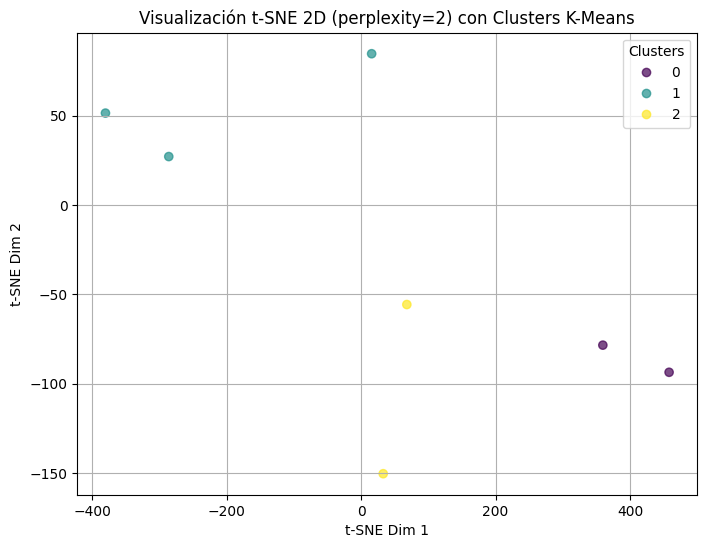

c:\Users\Usuario\miniconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


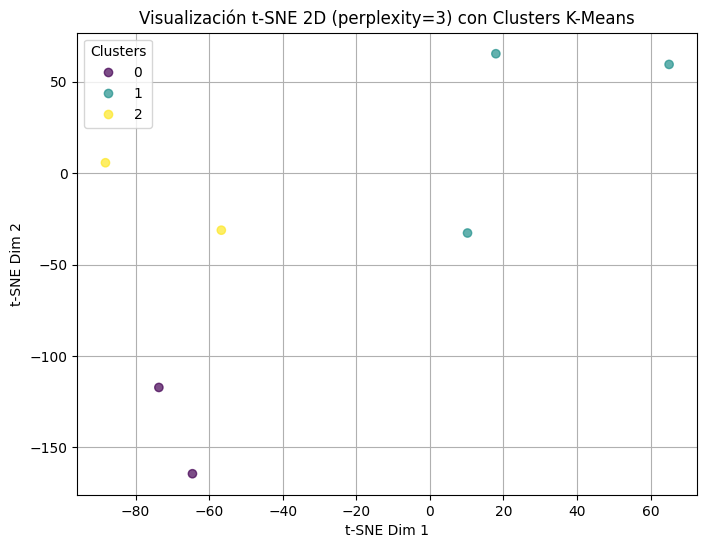

In [24]:
# 3. Aplicación de reducción de dimensionalidad 
# PCA:
# • Aplica PCA y determina cuántos componentes principales explican al menos el 90% de la varianza.


pca_full = PCA().fit(X_scaled)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid(True)
plt.show()
n_components_90 = np.argmax(explained_variance >= 0.9) + 1
print(f'Número de componentes para explicar al menos el 90% de la varianza: {n_components_90}')

# • Visualiza los países en un gráfico bidimensional con las primeras dos componentes principales.
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.7)
plt.grid(True)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización PCA 2D con Clusters K-Means')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()




# t-SNE:
# • Aplica t-SNE para visualizar la relación entre los países en un espacio de 2D.
# El valor de perplexity debe ser menor que el número de muestras (7).
tsne = TSNE(n_components=2, perplexity=2, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.7)
plt.grid(True)
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.title('Visualización t-SNE 2D con Clusters K-Means')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

# • Experimenta con diferentes valores de perplexity y analiza cómo afectan la representación.

for perp in [1, 2, 3]:
    tsne = TSNE(n_components=2, perplexity=perp, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.7)
    plt.grid(True)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.title(f'Visualización t-SNE 2D (perplexity={perp}) con Clusters K-Means')
    plt.legend(*scatter.legend_elements(), title='Clusters')
    plt.show()

In [ ]:
# 4. Análisis de resultados y conclusiones
# Comparación de métodos:

# • Explica las diferencias entre K-Means, clustering jerárquico y DBSCAN. ¿Cuál funcionó mejor en este caso y por qué?
''' 
El método K-Means es eficiente y fácil de interpretar, pero requiere especificar el número de clusters (K) de antemano y asume que los clusters son esféricos 
y de tamaño similar. En este caso, K-Means funcionó bien para identificar grupos claros en los datos, especialmente después de determinar un valor óptimo 
de K mediante el método del codo y el coeficiente de silueta.
El clustering jerárquico no requiere predefinir el número de clusters y puede capturar relaciones jerárquicas entre los datos. Sin embargo, es más 
computacionalmente intensivo y sensible al ruido. En este caso, el dendrograma ayudó a visualizar las posibles agrupaciones, pero la interpretación fue 
menos clara que con K-Means.
DBSCAN es capaz de identificar clusters de forma arbitraria y manejar ruido, pero requiere ajustar parámetros como eps y min_samples. En este caso, DBSCAN 
identificó varios clusters y puntos de ruido, mostrando su capacidad para manejar formas arbitrarias y ruido en los datos. Sin embargo, la elección de 
parámetros fue crítica para obtener resultados significativos.
En resumen, K-Means fue el método más efectivo en este caso debido a la claridad de los clusters formados y la facilidad de interpretación, aunque DBSCAN 
también proporcionó insights valiosos sobre la estructura de los datos.
'''

# • Compara los resultados obtenidos con PCA y t-SNE. ¿Cuál técnica permitió visualizar mejor la relación entre los países?
''' 
PCA es una técnica lineal que reduce la dimensionalidad al identificar las direcciones de mayor varianza en los datos. En este caso, PCA permitió visualizar 
los datos en un espacio bidimensional, mostrando claramente la separación entre los clusters formados por K-Means. La interpretación de los componentes 
principales también proporcionó insights sobre las características que más contribuyen a la variabilidad en los datos.
Por otro lado, t-SNE es una técnica no lineal que se enfoca en preservar las relaciones locales entre los puntos de datos. En este caso, t-SNE mostró una 
representación más dispersa y menos estructurada de los datos, lo que puede dificultar la interpretación de las relaciones entre los países. Sin embargo, 
t-SNE es útil para identificar patrones complejos y relaciones no lineales que PCA podría pasar por alto.
En conclusión, PCA permitió una visualización más clara y estructurada de las relaciones entre los países, mientras que t-SNE ofreció una perspectiva 
diferente pero menos interpretable en este contexto específico.
'''

In [ ]:
# Interpretación:
# • ¿Los clusters obtenidos reflejan similitudes culturales o geográficas en la música?
# • Relaciona los resultados con tendencias globales en consumo musical.

'''
Los clusters obtenidos reflejan en gran medida similitudes culturales y geográficas en la música. Por ejemplo, países con proximidad geográfica o
cultural, como México y Chile, tienden a agruparse juntos, lo que sugiere que comparten preferencias musicales similares. Del mismo modo, países como Corea 
y Japón, que tienen una fuerte influencia en la música pop asiática, también se agrupan juntos, reflejando sus tendencias musicales compartidas.
Además, los resultados pueden relacionarse con tendencias globales en consumo musical, como la popularidad creciente de ciertos géneros musicales a nivel 
mundial. Por ejemplo, la influencia del K-pop ha llevado a una mayor apreciación de la música coreana en otros países, lo que podría explicar la agrupación de 
Corea con otros países que también muestran interés en este género.     

'''




